# Sujet 5 : Prévoir la pollution de l'air à partir de données météo

Il s’agit de prévoir la concentration en polluants dans différentes villes françaises à partir de données météorologiques (vent, précipitations, etc.).

Les données météorologiques sont issues du [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home) du programme Copernicus.

La variable à prédire est la concentration en particules fines dites [PM<sub>2.5</sub>](https://www.airparif.asso.fr/les-particules-fines), c'est-à-dire dont le diamètre est inférieur à 2.5 μm. Ces particules sont néfastes pour la santé.

Le problème peut être traité en appliquant des algorithmes de machine learning supervisé tels que la régression logistique, les forêts aléatoires, les Gradient Boosted Trees ou encore les réseaux de neurones.

## Import des packages et chargement des données

On commence par importer les packages nécessaires.

In [1]:
# Chargement des données
import s3fs

# Manipulation des données
import numpy as np
import pandas as pd

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Les données sont stockées sur un serveur distant nommé S3. Il faut passer une instruction pour configurer la connexion au serveur.

In [2]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': "https://minio.lab.sspcloud.fr"})

On définit ensuite le chemin d'accès au fichier.

In [3]:
bucket = "projet-funathon/diffusion/2022/Sujet 5/"
file = "donnees_meteo_pollution.csv"
filepath = bucket + file

On peut finalement lire le fichier. On utilise la librairie pandas qui permet de manipuler les données sous forme de DataFrames.

In [4]:
with fs.open(filepath, mode="rb") as f:
    df = pd.read_csv(f)

## Statistiques descriptives

Les données concernent la période 2013-2021 et couvrent les villes de Paris, Lyon, Rennes, Troyes, Reims, Marseille, Montpellier, Toulouse, Bordeaux, Lorient, Limoges, ainsi que la forêt de Chizé. Cependant, la concentration en particules fines (la variable cible) n'est pas disponible pour toutes les villes sur toute la période. Cela dépend de la date de mise en service des stations de mesure.

Les variables explicatives disponibles sont les suivantes :
- blh : "boundary layer height", c'est la hauteur de la couche limite, c'est-à-dire la hauteur de la partie la plus basse de l'atmosphère
- msl : "mean sea level pressure", c'est la pression moyenne au niveau de la mer
- t2m : température à 2m de la surface
- tcc : "total cloud cover", c'est la proportion du ciel couvert par des nuages
- tp : précipitations totales
- u10 : vitesse du vent allant vers l'est, à 10 mètres de la surface (peut être négatif pour un vent vers l'ouest)
- v10 : vitesse du vent allant vers le nord, à 10 mètres de la surface (peut être négatif pour un vent vers le sud)

In [5]:
list(df.columns)

['station',
 'geometry',
 'date',
 'blh',
 'v10',
 't2m',
 'tcc',
 'u10',
 'tp',
 'msl',
 'pm2.5']

On peut voir à quoi ressemblent les données en affichant les 5 premières lignes.

In [6]:
df.head()

station                   geometry        date        blh       v10  \
0  Rennes  POINT (-1.66586 48.10861)  2019-12-05    93.1441  0.843679   
1  Rennes  POINT (-1.66586 48.10861)  2020-02-08   608.7348  2.879636   
2  Rennes  POINT (-1.66586 48.10861)  2019-12-22  1262.9279  0.837496   
3  Rennes  POINT (-1.66586 48.10861)  2019-11-03   889.6064  0.560826   
4  Rennes  POINT (-1.66586 48.10861)  2020-02-26  1128.0018 -0.736067   

         t2m        tcc       u10            tp         msl  pm2.5  
0  273.38644  79.977290  0.613651  1.986821e-07  102389.805   37.7  
1  282.46640  82.402550  2.110329  1.981258e-04  101966.336   12.7  
2  282.61716  55.098600  7.014151  8.684397e-05   99428.270   13.4  
3  284.66104  82.739006  3.167545  5.463560e-04   98569.530    9.4  
4  279.11987  73.312630  5.178663  1.833836e-05  101240.100   11.8

La méthode `describe` permet d'afficher des statistiques sur les colonnes numériques du dataframe.

In [7]:
df.describe()

blh           v10           t2m           tcc           u10  \
count  39444.000000  39444.000000  39444.000000  39444.000000  39444.000000   
mean     559.846643     -0.045356    286.351657     58.730117      0.797067   
std      269.021362      2.595531      6.315650     29.958656      2.744629   
min       25.004328    -11.689630    266.887800      0.000000    -13.845531   
25%      360.009405     -1.754657    281.783150     36.020628     -0.881724   
50%      535.361220     -0.095893    286.061820     64.150750      0.728299   
75%      720.653930      1.686096    291.058238     84.182960      2.449817   
max     2035.275400     11.970455    306.370120    100.000000     13.773787   

                 tp            msl         pm2.5  
count  3.944400e+04   39444.000000  23889.000000  
mean   9.737180e-05  101697.702068     20.923182  
std    1.968842e-04     818.990115     15.605765  
min    0.000000e+00   97617.280000      0.000000  
25%    3.973643e-08  101258.985000     10.900000  
50%    1.124541e-05  101724.180000     16.500000  
75%    1.025498e-04  102201.602000     25.600000  
max    3.046274e-03  104570.945000    302.500000

On peut aussi calculer séparément les grandeurs qui nous intéressent, comme la moyenne de la variable cible.

In [8]:
df['pm2.5'].mean()

20.923182217756366

On va tracer l'évolution de la concentration en particules fines à Paris et Lyon au cours du temps. Pour cela, il faut d'abord isoler les données de chaque ville, puis transformer le champ date, stocké comme une chaîne de caractère, en un champ temporel.

In [9]:
df_paris = df[df['station'] == 'Paris'].copy()
df_paris['date'] = pd.to_datetime(df_paris['date'])

In [10]:
df_paris

station                   geometry       date         blh       v10  \
3287   Paris  POINT (2.344616 48.86212) 2017-07-07   685.36250 -1.230187   
3288   Paris  POINT (2.344616 48.86212) 2017-04-04   523.72860 -2.511983   
3289   Paris  POINT (2.344616 48.86212) 2017-02-27  1326.36320  6.404028   
3290   Paris  POINT (2.344616 48.86212) 2017-07-09   475.68372 -1.550982   
3291   Paris  POINT (2.344616 48.86212) 2017-01-16   289.01718 -1.865335   
...      ...                        ...        ...         ...       ...   
6569   Paris  POINT (2.344616 48.86212) 2019-04-08   435.55396  0.042396   
6570   Paris  POINT (2.344616 48.86212) 2019-01-30   568.46040 -0.195133   
6571   Paris  POINT (2.344616 48.86212) 2018-12-31   216.98848 -0.980804   
6572   Paris  POINT (2.344616 48.86212) 2019-05-02   534.27470 -2.078988   
6573   Paris  POINT (2.344616 48.86212) 2019-04-25   795.19120  4.676176   

            t2m        tcc       u10        tp         msl  pm2.5  
3287  298.79822   7.856878  1.737242  0.000001  101655.000    NaN  
3288  284.55880  47.026188  0.671355  0.000002  102431.445    NaN  
3289  282.20273  80.428696  3.801638  0.000234  100044.445    NaN  
3290  295.58194  77.934265 -0.950254  0.000390  101169.000    NaN  
3291  274.29404  88.031760 -1.297495  0.000002  102651.900    NaN  
...         ...        ...       ...       ...         ...    ...  
6569  284.66837  76.478580  0.952115  0.000007  101080.380    NaN  
6570  274.38620  79.694370  3.923699  0.000328   99611.125    NaN  
6571  281.17117  99.869530  1.246305  0.000031  103662.650    NaN  
6572  284.09756  96.540955  2.394858  0.000259  101441.010    NaN  
6573  284.02017  91.147360  0.331477  0.000354  100406.040    NaN  

[3287 rows x 11 columns]

[Text(0.5, 1.0, 'Evolution de la concentration en particules fines à Paris')]

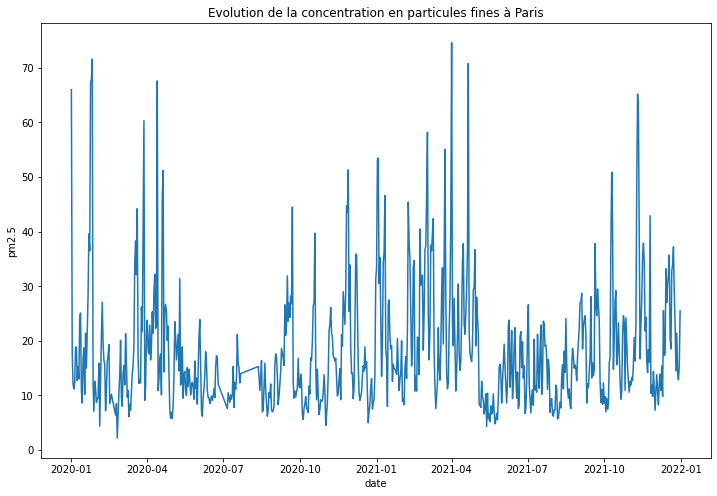

In [11]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_paris, x="date",y="pm2.5").set(title="Evolution de la concentration en particules fines à Paris")

L'historique est plus grand pour Lyon, mais on ne dispose pas des données pour l'année 2018.

[Text(0.5, 1.0, 'Evolution de la concentration en particules fines à Lyon')]

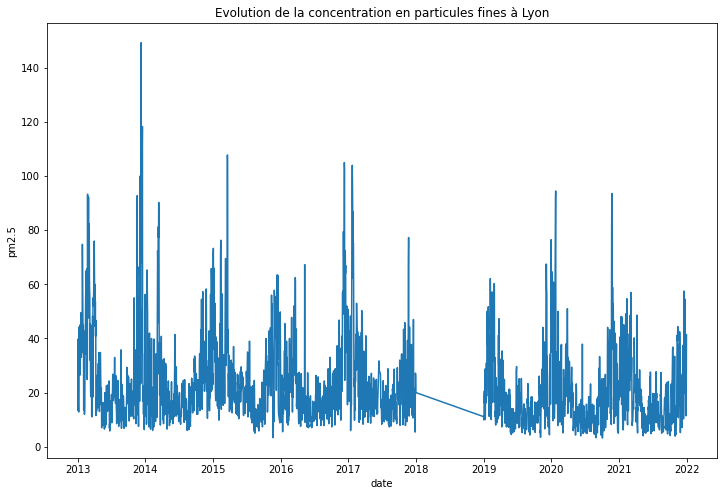

In [15]:
df_lyon = df[df['station'] == 'Lyon'].copy()
df_lyon['date'] = pd.to_datetime(df_lyon['date'])
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_lyon, x="date",y="pm2.5").set(title="Evolution de la concentration en particules fines à Lyon")

On regarde si les données contiennent des valeurs manquantes. Ici, il n'y a que la variable cible qui en a, lorsque l'on ne dispose pas de mesures de pollution pour une ville et un jour donné.

In [16]:
df.isna().sum()

station         0
geometry        0
date            0
blh             0
v10             0
t2m             0
tcc             0
u10             0
tp              0
msl             0
pm2.5       15555
dtype: int64

## Premiers modèles

Pour entraîner les modèles de machine learning, on va utiliser la librairie [_scikit-learn_](https://scikit-learn.org/stable/getting_started.html) qui propose une syntaxe commune pour un grand ensemble de modèles différents. Elle contient aussi des fonctions auxiliaires de preprocessing ou d'évaluation des résultats.

Cette librairie étant très populaire au sein de la communanuté du machine learning, on trouve souvent les réponses à ses questions ainsi que des exemples de code sur des sites d'entraide tels que _stackoverflow_.

#### Gestion des valeurs manquantes

On commence par gérer les valeurs manquantes. Ici, pas d'imputation possible puisque c'est la variable cible qui est manquante. On supprime donc les lignes concernées.

In [17]:
df = df[~df['pm2.5'].isna()] #Le symbole ~ représente la négation pour pandas

#### Création des échantillons de test et d'entraînement

On sépare ensuite les variables explicatives X de la variable cible y.

In [18]:
X = df[['blh', 'msl', 't2m', 'tcc', 'tp', 'u10', 'v10']].copy() #variables explicatives
y = df['pm2.5'].copy() #variable à prédire

Puis on sépare les données en deux échantillons : 
- un échantillon d'entraînement que l'on va fournir aux modèles pour les calibrer,
- un échantillon de test pour évaluer les performances des modèles et les comparer.

L'échantillon d'entraînement représente 80% des lignes, et l'échantillon de test les 20% restants.

On utilise une graine pour initialiser le générateur de nombres aléatoires, par l'intermédiaire de la variable _random_state_, arbitrairement fixée à 42 ici (tout autre nombre aurait fonctionné). Cette graine permet de rendre le découpage des échantillons déterministe. Sans elle, le découpage serait différent à chaque exécution de la fonction, ce qui ferait fluctuer les performances du modèle.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#### Régression linéaire

On commence par une simple régression linéaire. C'est toujours une bonne base de comparaison dans un problème de régression (prédiction d'une variable continue). La méthode `fit` permet d'entraîner le modèle.

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Notre premier modèle est entraîné ! On peut maintenant effectuer les prédictions sur l'échantillon de test.

In [21]:
predictions = lr.predict(X_test)

Il nous reste à mesurer ses performances. Plusieurs mesures existent. Ici on utilise la racine de l'erreur quadratique moyenne, souvent dénotée par son acronyme anglais RMSE.

In [22]:
RMSE = np.sqrt(((predictions - y_test) ** 2).mean())
print(RMSE)

14.109083958521081


Notez qu'il existe également une fonction dédiée dans le package scikit learn.

In [23]:
RMSE_avec_scikitlearn = mean_squared_error(y_test, predictions, squared=False)
print(RMSE_avec_scikitlearn)

14.109083958521083


#### Forêt aléatoire

Essayons maintenant un modèle de forêt aléatoire. Il s'agit d'un modèle reposant sur un ensemble (parfois très grand !) d'arbres de décision. Notre forêt contient 100 arbres (c'est le rôle de l'hyperparamètre _n_estimators_). Il y a de l'aléatoire dans la construction des arbres, on utilise donc ici aussi une graine pour la reproductibilité de l'entraînement.

In [24]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

On peut à nouveau effectuer les prédictions sur l'échantillon de test et mesurer les résultats.

In [25]:
predictions = rf.predict(X_test)

In [26]:
RMSE = np.sqrt(((predictions - y_test) ** 2).mean())
print(RMSE)

13.465737839011057


L'erreur moyenne de nos prédictions sur la concentration en particules fines est donc de l'ordre de 13 μm. C'est mieux que la régression linéaire, mais cela reste très mauvais (pour rappel, la concentration moyenne sur notre jeu de données est de l'ordre de 21 μm). Il y a du travail pour améliorer notre modèle !

## Comment poursuivre ?

- Ajouter des variables explicatives (ex : le jour de la semaine pour tenir compte de la variation du trafic routier)
- Essayer d'autres modèles (Gradient Boosted Trees, SVM, etc.)
- Faire varier les hyperparamètres des modèles
- Interpréter les résultats d'un modèle (importance des variables, disribution des erreurs, etc.)
- Prendre en compte la composante temporelle
- Prendre en compte la composante géographique en distinguant les stations de mesure (Comment ? Un modèle par station ou un modèle global avec la station comme variable explicative ?)